 ## $\underline{ \textbf{Data assimilation on a PAPA}}$
 
 
 
 **Statut** : In progress
 
**Purpose**: We propose here an assimilation problem coupled with Solver DL (deep learning), the goal is to infer the mass **m** and the moment of inertia **$I_\alpha$** of a PAPA from observations made on the displacements.
 
 
 **Reference** : 
 
 [1] : [ V. Mons, J.-C. Chassaing, T. Gomez, P. Sagaut, "Reconstruction of unsteady viscous flows using data assimilation schemes", JCP 316 (2016) p. 255-280.](https://dropsu.sorbonne-universite.fr/s/oP8s9CeNS5zW5DG)
 
 [2] : [ A. Chaarane, "Data Assimilation for Flow Induced Vibrations",Stage, InstitutJean Le Rond D’Alembert, 2021.](https://dropsu.sorbonne-universite.fr/s/kr97PiKoJ8jFHfw)
 
 
-----------------------------------
**A. Chaarane**, Institute  D'Alembert, (13 Juin 2022)

-----------------------------------

In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
import os
import sys
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import copy
from tabulate import tabulate

# ------ Importation Local
# utils for Post-Trait ( plot, ..)
sys.path.append("../")
from Post_Trait import POSTRAIT
Path_src     = "../../"
#--- DATA : output of DA code

#--- Config 
PATH_CONF = Path_src+"Inference_Problem/PAPA/" 
sys.path.append(PATH_CONF)


In [13]:
PST_dic = {}
List_color =  ["black","grey", "blue", "red", "cyan", "green", "orange","purple", "pink"]
k=0
# ### ----------------------------- :
# Path_res       = "PAPA/MassIalpha/"
# PATH_DATA      = Path_src+"DATA_SWAG_29_09_2022/DA_4DEnVar_V2/"+Path_res
# label          = "EnVar"
# color          = List_color[k]
# PST_dic[label] = POSTRAIT(PATH_DATA,label=label,color=color)
# k+=1

Path_res       = "PAPA/MassIalpha/"
PATH_DATA      = Path_src+"DATA/DA_4DEnVar_V2/"+Path_res
label          = "EnVar-DL"
color          = List_color[k]
PST_dic[label] = POSTRAIT(PATH_DATA,label=label,color=color)
k+=1

Path_res       = "PAPA_SWAG_V0/MassIalpha/"
PATH_DATA      = Path_src+"DATA_SWAG_29_09_2022/DA_4DEnVar_V2/"+Path_res
label          = "EnVar-DL-SWAG(V0)"
color          = List_color[k]
PST_dic[label] = POSTRAIT(PATH_DATA,label=label,color=color)
k+=1

Path_res       = "PAPA_SWAG_V1/MassIalpha/"
PATH_DATA      = Path_src+"DATA_SWAG_29_09_2022/DA_4DEnVar_V2/"+Path_res
label          = "EnVar-DL-SWAG(V1)"
color          = List_color[k]
PST_dic[label] = POSTRAIT(PATH_DATA,label=label,color=color)
k+=1

Path_res       = "PAPA_SWAG_V2/MassIalpha/"
PATH_DATA      = Path_src+"DATA_SWAG_29_09_2022/DA_4DEnVar_V2/"+Path_res
label          = "EnVar-DL-SWAG(V2)"
color          = List_color[k]
PST_dic[label] = POSTRAIT(PATH_DATA,label=label,color=color)
k+=1

### Control Vectors  

In [14]:
all_gamma = [PST_dic[label].CFG.Param_Ref, PST_dic[label].CFG.Param_Est]
index   = ["Reference","Initialisation"]

for key, PST in PST_dic.items() :
    all_gamma.append(PST.Param_Opti)
    index.append("Optimized {"+PST.label+"}")
    
df =pd.DataFrame(all_gamma, index = index,columns=PST_dic[label].CFG.Param_Name)    

print(tabulate(df, tablefmt='grid',headers='keys'))
print("")    

+-------------------------------+---------+-----------+
|                               |    mass |   I_alpha |
+===============================+=========+===========+
| Reference                     | 87.07   |   3.73    |
+-------------------------------+---------+-----------+
| Initialisation                | 75      |   1.8     |
+-------------------------------+---------+-----------+
| Optimized {EnVar-DL}          | 87.0812 |   3.72506 |
+-------------------------------+---------+-----------+
| Optimized {EnVar-DL-SWAG(V0)} | 87.0697 |   3.72665 |
+-------------------------------+---------+-----------+
| Optimized {EnVar-DL-SWAG(V1)} | 87.0782 |   3.72965 |
+-------------------------------+---------+-----------+
| Optimized {EnVar-DL-SWAG(V2)} | 87.083  |   3.72856 |
+-------------------------------+---------+-----------+



### Function Cost  and HF ratio


$\newcommand{\Gama}{\boldsymbol{\gamma}} 
\newcommand{\B}{\boldsymbol{B}} 
\newcommand{\C}{\boldsymbol{C}} 
\newcommand{\Gamae}{\boldsymbol{\gamma}^{(e)}}
\newcommand{\YN}{( \boldsymbol{y}{_k})_{0\leq k\leq N}}
\newcommand{\XN}{( \boldsymbol{x}{_k})_{0\leq k\leq N}}
\newcommand{\Ep}{ \boldsymbol{E}'}
\newcommand{\Beta}{ \boldsymbol{\beta}}
\newcommand{\h}{ \boldsymbol{h}}
\newcommand{\x}{ \boldsymbol{x}}
\newcommand{\y}{ \boldsymbol{y}}$



\begin{equation}
    J = \underbrace{\frac{1}{2} \Vert \Gama-\Gamae \Vert ^2_{\B^{-1}} }_{J_b}+\underbrace{\frac{1}{2} \sum_{k=0}^{N} \Vert \boldsymbol{y}_k -\boldsymbol{h}(\boldsymbol{x}_k) \Vert^2_{\C^{-1}}}_{J_{obs}}
    \label{eq_J}
\end{equation}



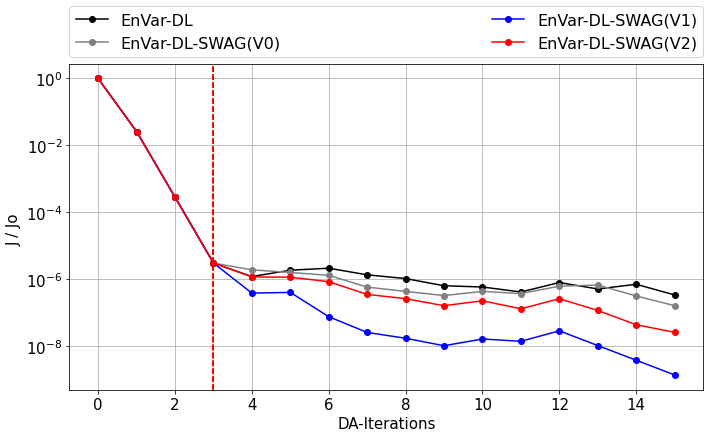

In [15]:
plt.figure(figsize=(25,6))
plt.subplot(1,2,1)
for key, PST in PST_dic.items() :
    PST.plot_Jcost(linestyle='-o')
    if PST.CFG.Use_DL:
        plt.axvline(x=PST.i_start_ML,c="r",linestyle='--')
    
plt.grid(True)
plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=2,fontsize=16)

# plt.subplot(1,2,2)
# for key, PST in PST_dic.items() :
#     PST.plot_HF_ratio(linestyle='--o')
#     if PST.CFG.Use_DL:
#         plt.axvline(x=PST.i_start_ML,c="r",linestyle='--')
    
# plt.grid(True)
# plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
#                             mode="expand", borderaxespad=0, ncol=2,fontsize=16)
# plt.ylim(30,105)
# plt.show()

In [21]:
from numpy import linalg as la
import numpy as np

x = np.array([89, 34, 56, 87, 90, 23, 45, 12, 65, 78, 9, 34, 12, 11, 2, 65, 78, 82, 28, 78]) 

norm = la.norm(x,2) 
norm

257.4800963181426

In [37]:
A = np.ones((2,3,3))
a = np.sum(A)
a

18.0

In [30]:
np.dot (A,A.T)

array([[3., 3.],
       [3., 3.]])

##  Relative Error  

$$ e_r = \frac{\gamma_{opti} - \gamma_{ref} } {\gamma_{ref}} \times 100$$

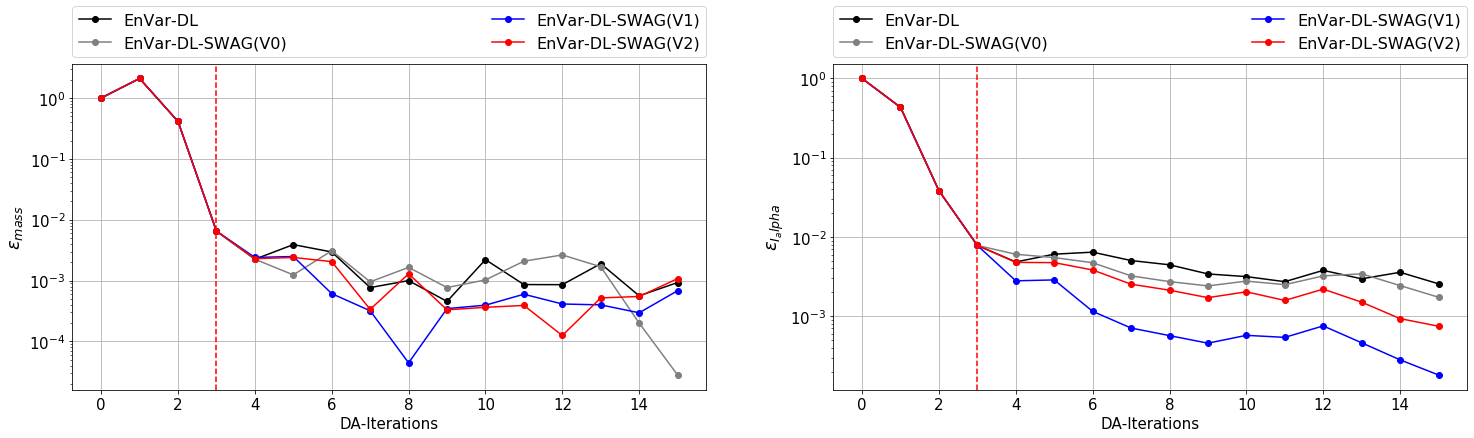

In [120]:
n_col = len(PST.CFG.Param_Name)
plt.figure(figsize=(25,6))

k=1

for i,name in enumerate(PST.CFG.Param_Name) :
    
    plt.subplot(1,n_col,k)
    for key, PST in PST_dic.items() :
        
        N_iter  = [j for j in range(len(PST.Param_error))]
        plt.plot(N_iter, PST.Param_error[:,i]/PST.Param_error[0,i],'-o', c=PST.color,label = PST.label)
    plt.ylabel(r"$\epsilon_{"+PST.CFG.Param_Name[i]+"}$",fontsize=18)
        
    new_list = range(math.floor(min(N_iter)), math.ceil(max(N_iter))+1,2)
    plt.xticks(new_list, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('DA-Iterations',fontsize=15)
    plt.yscale("log")
    plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                            mode="expand", borderaxespad=0, ncol=2,fontsize=16)    
    plt.grid()
    plt.axvline(x=PST.i_start_ML,label="Start DL coupled",c="r",linestyle='--')
    
    if k ==n_col and i!=len(PST.CFG.Param_Name)-1:
        plt.show()
        plt.figure(figsize=(20,4))
        k=1
    else :
        k+=1


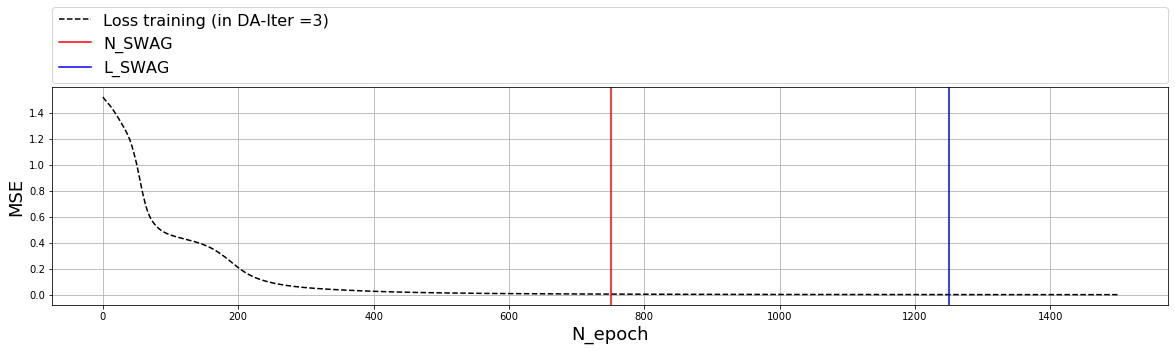

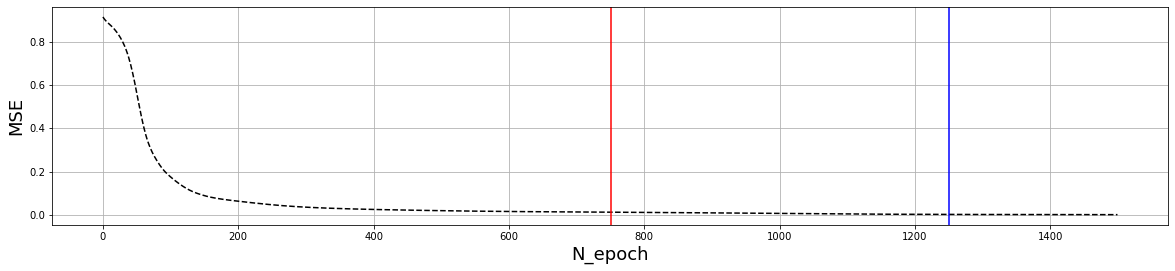

<Figure size 1440x288 with 0 Axes>

In [88]:
label = "EnVar-DL-SWAG(V2)"
PST_dic[label].plot_train_loss(n_col=1)

## Reconstruction of Observables 

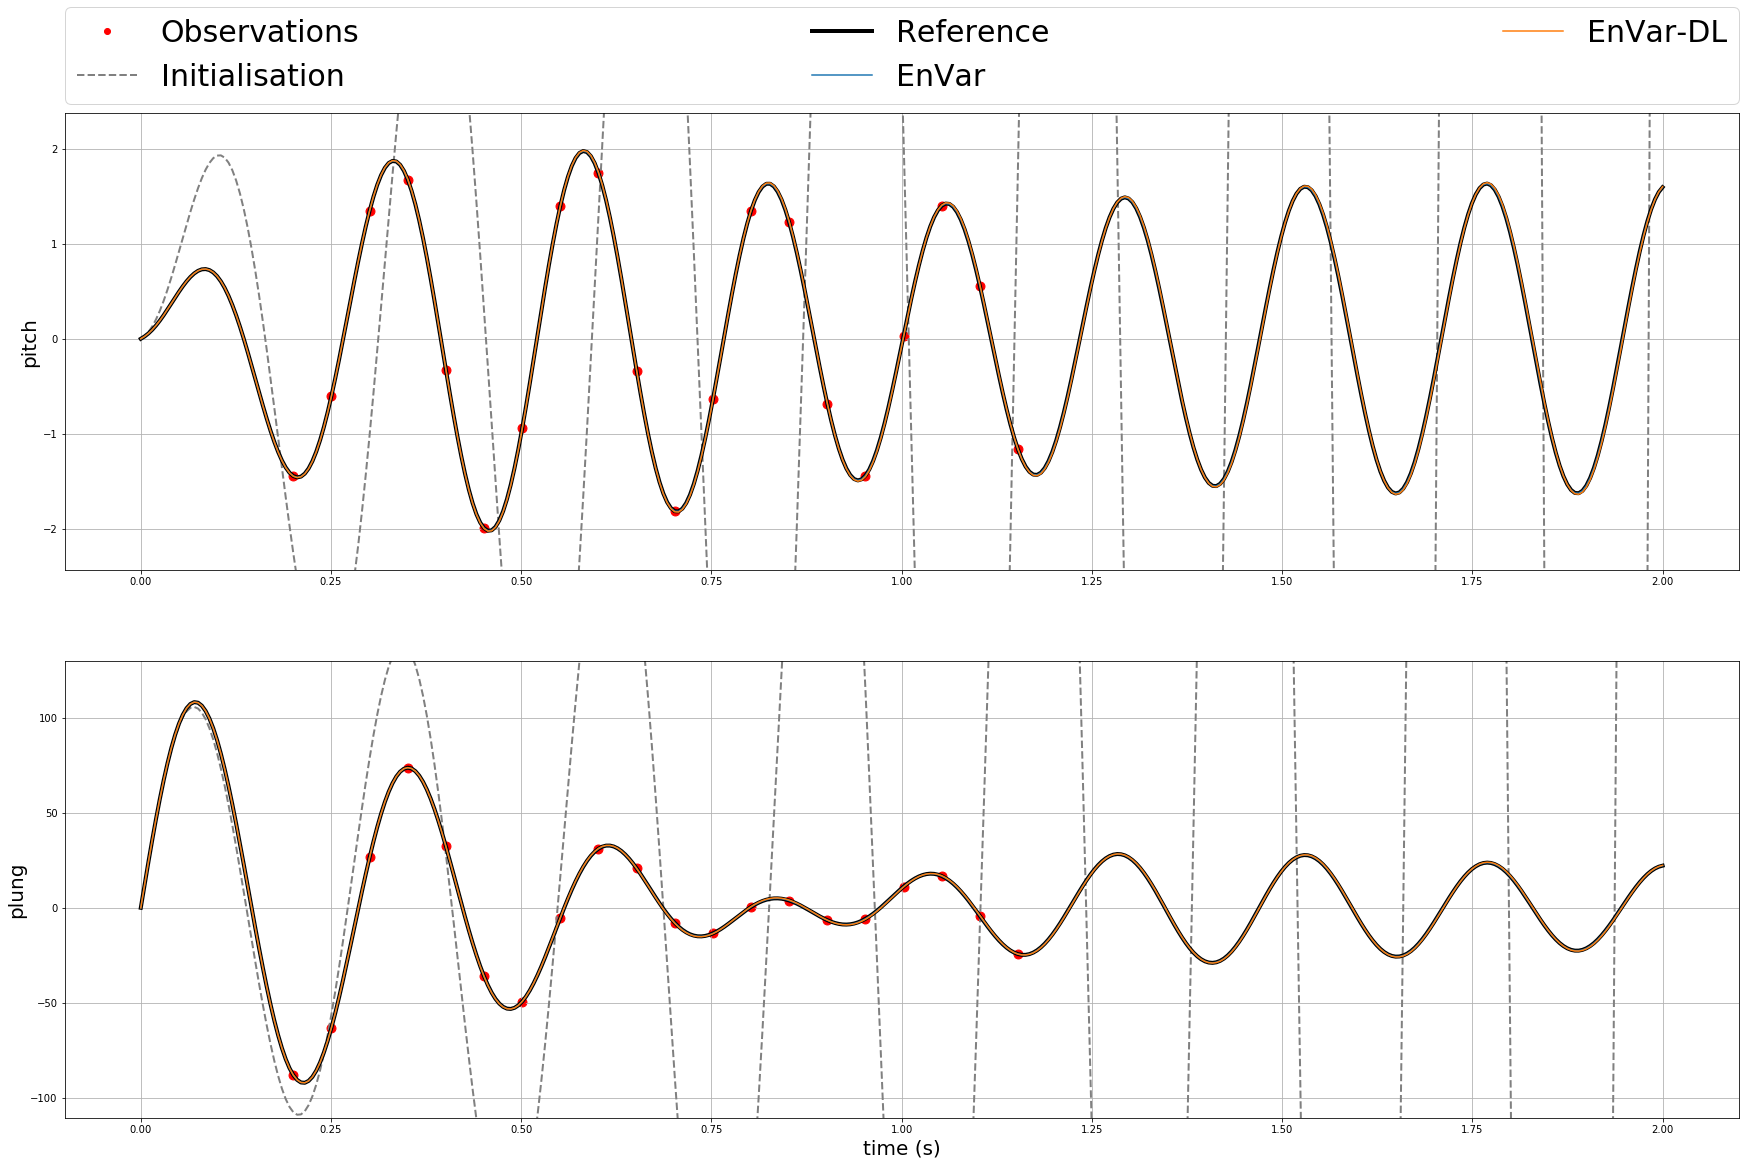

In [28]:
plt.figure(figsize=(30,200))
for i,name_obs in enumerate(PST_dic[label].CFG.Obs_Name) :
    plt.subplot(PST_dic[label].CFG.Number_Observation, 1 , i+1)
    plt.plot(PST_dic[label].time_obs, PST_dic[label].observations[:,i], 'o',color='r',label='Observations')
    plt.plot(PST_dic[label].time,PST_dic[label].observables_est[:,i],'--',color='grey',label='Initialisation' ,linewidth=2)
    plt.plot(PST_dic[label].time,PST_dic[label].observables_ref[:,i],'-',color='k',label='Reference',linewidth=4)
    k =0
    for key, PST in PST_dic.items():
        plt.plot(PST.time,PST.observables_opti[:,i],label=PST.label )
    plt.scatter(PST_dic[label].time_obs, PST_dic[label].observations[:,i], marker='o',color='r',s=80)
    v_min = np.min(PST_dic[label].observables_opti[:,i]) ; v_min=v_min - (v_min/abs(v_min))*v_min*0.2
    v_max = np.max(PST_dic[label].observables_opti[:,i]) ; v_max=v_max + (v_max/abs(v_max))*v_max*0.2 
    plt.ylabel(name_obs,fontsize=20)
    plt.ylim([v_min,v_max])
    plt.grid()
    if   i== 0:
        plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                    mode="expand", borderaxespad=0, ncol=3,fontsize=30)
plt.xlabel('time (s)',fontsize=20)
plt.show()

In [29]:
df_samples = copy.copy(PST.get_ensembles_df())
df_samples["Status"] =""
# df_samples

In [30]:
def Calc_Param_bar(df_Param,CFG):
    df_Param_bar =copy.copy(df_Param)
    for i,parm_nm in enumerate(CFG.Param_Name): 
        df_Param_bar[parm_nm] =( 2*df_Param[parm_nm] - CFG.Param_Bounds[i][0] -CFG.Param_Bounds[i][1])\
                        / (CFG.Param_Bounds[i][1]-CFG.Param_Bounds[i][0])
    return df_Param_bar

def Calc_Param(df_Param_bar,CFG):
    df_Param =copy.copy(df_Param_bar)
    for i,parm_nm in enumerate(CFG.Param_Name): 
        df_Param[parm_nm] =0.5*(CFG.Param_Bounds[i][1] -CFG.Param_Bounds[i][0])*df_Param_bar[parm_nm] + 0.5*(CFG.Param_Bounds[i][1] + CFG.Param_Bounds[i][0])
    return df_Param

In [32]:
name_file =PST_dic[label].CFG.Path_Ensemble+'Iter_'+str(12)+'/' +"DataFram_Param_ens_bar"+PST_dic[label].CFG.ext

df_Param_Ens_bar = pd.read_csv(name_file)
df_Param_Ens_bar =Calc_Param(df_Param_Ens_bar,PST_dic[label].CFG)

In [33]:
df_Param_Ens_bar

,Unnamed: 0,mass,I_alpha,Sample,DA_Iter,Solver,Training,Prediction
0,0,67.978416,1.786060,0,0.0,PAPA,False,False
1,1,72.205822,1.140939,1,0.0,PAPA,False,False
2,2,81.353758,1.585471,2,0.0,PAPA,False,False
3,3,71.487889,2.281620,3,0.0,PAPA,False,False
4,4,69.229683,1.202634,4,0.0,PAPA,False,False
...,...,...,...,...,...,...,...,...
385,385,89.674472,3.545752,25,12.0,FNN,False,True
386,386,95.277800,3.284417,26,12.0,PAPA,False,False
387,387,83.533459,3.100425,27,12.0,PAPA,True,False
388,388,95.700596,4.504435,28,12.0,PAPA,False,False


### Sample analysis during the optimisation process. 

In [34]:
def SADOP(PST,col_wrap=4, Zoom = False, dim_bar = True) : 
    df_samples = PST.get_DataFram()
    if dim_bar :
        df_samples =Calc_Param_bar(df_samples, PST.CFG)
        
    with sns.axes_style("darkgrid"):
        g=sns.FacetGrid(df_samples, col="DA_Iter", height=2.5, col_wrap=col_wrap)
        g.map_dataframe(sns.scatterplot, x=PST.CFG.Param_Name[0], y=PST.CFG.Param_Name[1],style ="Solver",palette="coolwarm")



        k = 0
        i_start_train = PST.i_start_ML -1
        for ax in g.axes.flatten() :

            ## ---- all old samples :
            if k>0 :
                if Zoom and k > PST.i_start_ML+2:
                    df_samples_old = df_samples.loc[ (df_samples["DA_Iter"] <k) & (df_samples["DA_Iter"] >=PST.i_start_ML)].copy()
                else :
                    df_samples_old = df_samples.loc[ (df_samples["DA_Iter"] <k)].copy()
            else :
                df_samples_old = df_samples.loc[ (df_samples["DA_Iter"] ==k)].copy()
            sns.scatterplot(data=df_samples_old, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.1,color ="grey")


            ## ----- new samples (Current)
            
            df_samples_new = df_samples.loc[ (df_samples["DA_Iter"] ==k)].copy()

            ## update i start train 
            if PST.CFG.DL_Model not in df_samples_new["Solver"].values :
                i_start_train = k
            ## ---- Current train sample  
            if k>= PST.i_start_ML :
                name_file =PST.CFG.Path_Ensemble+'Iter_'+str(k)+'/' +"DataFram_Param_ens_bar"+PST.CFG.ext
                df_Param_Ens = pd.read_csv(name_file)
                if not dim_bar :
                    df_Param_Ens     = Calc_Param(df_Param_Ens,PST.CFG)
                df_sample_train  = df_Param_Ens.loc[df_Param_Ens["Training"]].copy()   
                sns.scatterplot(data=df_sample_train, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=0.8,color="g")

            sns.scatterplot(data=df_samples_new, x=PST.CFG.Param_Name[0], ax=ax,y=PST.CFG.Param_Name[1],style="Solver", alpha=1.,color="darkorange")



            k+=1
            ax.legend().remove() 
    # g.axes.flatten()[:].legend().remove()    
    g.fig.set_dpi(120)
    g.add_legend()
    
    # fix the legends

### 1- DL-EnVar

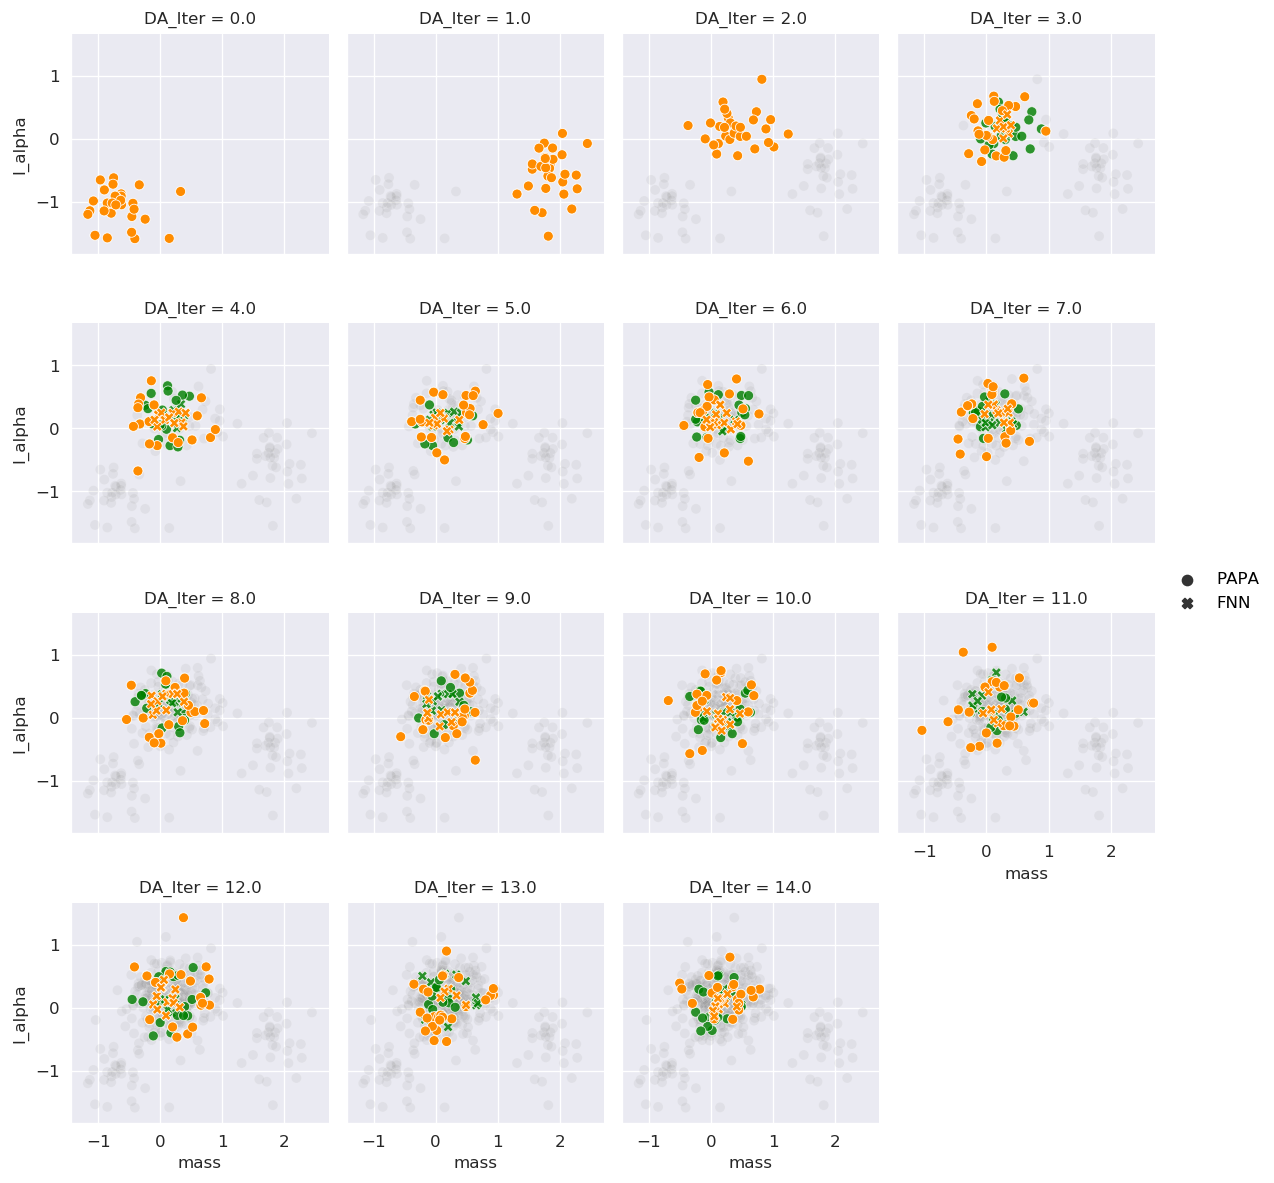

In [73]:
SADOP(PST_dic[label])

### 2- DL-EnVar-SWAG

In [23]:
df_samples = copy.copy(PST_dic[label3].get_ensembles_df())
df_samples["Status"] =""

SADOP(df_samples)

NameError: name 'label3' is not defined

In [ ]:
df_samples

In [ ]:
df_samples2_bar.loc[ (df_samples2_bar[PST.CFG.Param_Name[0]] ==prm[0]) &  \
                         (df_samples2_bar[PST.CFG.Param_Name[1]] ==prm[1])    ].index 

In [ ]:

param  = df_samples[PST.CFG.Param_Name ].values
param  = param[50]
print(param in df_samples[PST.CFG.Param_Name].values)

In [ ]:
def myfunct():
    code  = "test = df_samples.loc["
    for d in range(len( PST.CFG.Param_Name) ):
        code +="(df_samples[PST.CFG.Param_Name["+str(d)+"]]==param["+str(d)+"])"
        if d < len( PST.CFG.Param_Name)-1 :
            code+=" & "
        else :
            code+= " ]"
    exec(code,globals())
    return test
myfunct()

In [ ]:
test["Sample"].values[0]